In [2]:
from skimage.filters import roberts,sobel,scharr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import h5py as h5
import cv2

In [3]:
train_images_path = r'C:\Users\harsh\OneDrive\Desktop\ml cs460 project\craters\train_images.hdf5'
f = h5.File(train_images_path,'r')
input_images = f['input_images']
masks = f['target_masks']

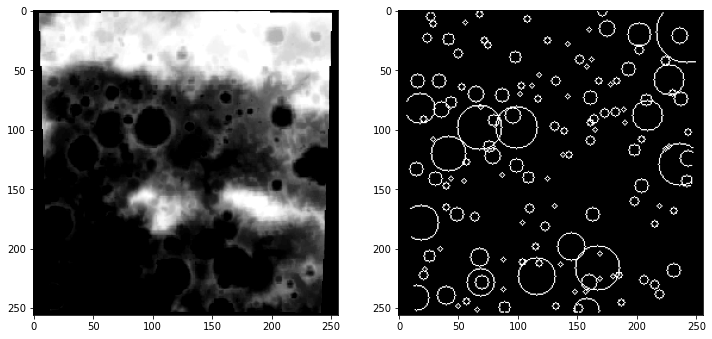

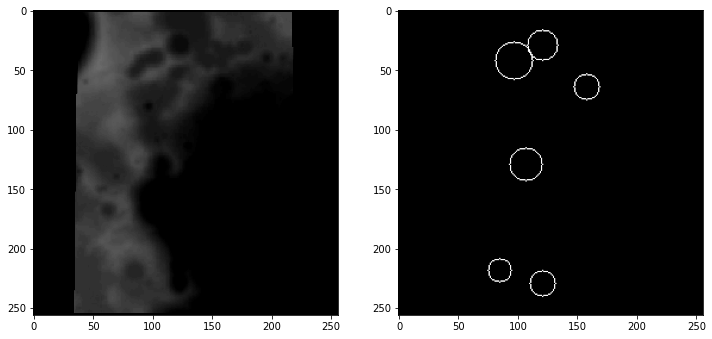

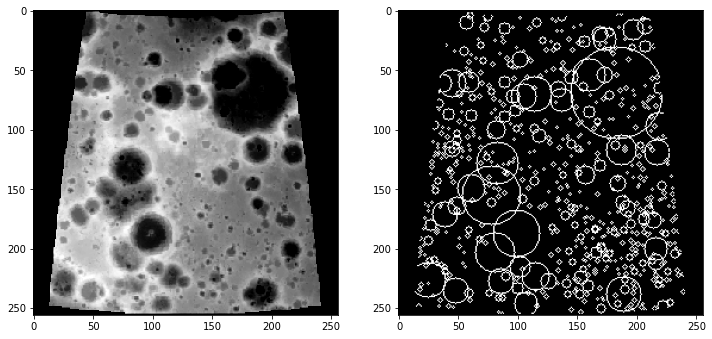

In [4]:
for i in np.arange(27,30):
    fig = plt.figure(figsize=[12, 6])
    [ax1, ax2] = fig.subplots(1,2)
    ax1.imshow(f['input_images'][i][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
    ax2.imshow(f['target_masks'][i][...], origin='upper', cmap='Greys_r')
    plt.show()

In [5]:
df = pd.DataFrame()

im1 =  input_images[15]
im2 =  input_images[16]
im3 =  input_images[17]

dem1 = input_images[15].reshape(-1)
dem2 = input_images[16].reshape(-1)
dem3 = input_images[17].reshape(-1)
pixels = np.concatenate((dem1,dem2,dem3))

#first feature of data will be just the pixel vals
df['pixel_vals'] = pixels

In [7]:
num = 1  #To count numbers up in order to give Gabor features a label in the data frame
kernels = []  #kernel bank
for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with values of 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                           
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                ksize=3
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg1 = cv2.filter2D(dem1, cv2.CV_8UC3, kernel)
                fimg2 = cv2.filter2D(dem2, cv2.CV_8UC3, kernel)
                fimg3 = cv2.filter2D(dem3, cv2.CV_8UC3, kernel)
                fimg = np.concatenate((fimg1,fimg2,fimg3))
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

In [8]:
# Canny edge
ec1 = cv2.Canny(im1,100,200)
ec2 = cv2.Canny(im2,100,200)
ec3 = cv2.Canny(im3,100,200)
ec = np.concatenate((ec1,ec2,ec3))
c_edges = ec.reshape(-1)
df['Canny Edges'] = c_edges

In [9]:
#Roberts
er1 = roberts(im1)
er2 = roberts(im2)
er3 = roberts(im3)
er = np.concatenate((er1,er2,er3))
r_edges = er.reshape(-1)
df['Roberts Edges'] = r_edges


In [10]:
#sobel
es1 = sobel(im1)
es2 = sobel(im2)
es3 = sobel(im3)
es = np.concatenate((er1,er2,er3))
s_edges = es.reshape(-1)
df['Sobel Edges'] = s_edges

In [11]:
#Scharr
eh1 = sobel(im1)
eh2 = sobel(im2)
eh3 = sobel(im3)
eh = np.concatenate((er1,er2,er3))
schrr_edges = eh.reshape(-1)
df['Scharr Edges'] = schrr_edges

In [12]:
#now that features are done, we will add the pixel labels from the masks
mask1 = masks[15]
mask2 = masks[16]
mask3 = masks[17]

y1 = mask1.reshape(-1)
y2 = mask2.reshape(-1)
y3 = mask3.reshape(-1)

y = np.concatenate((y1,y2,y3))
df['Labels'] = y

In [13]:
#splitting df into test and train
from sklearn.model_selection import train_test_split
Y = df['Labels'].values
X = df.drop(labels = ['Labels'],axis = 1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3,random_state = 1)

In [14]:
#SVM with RBF kernel
from sklearn.svm import SVC
from sklearn import metrics

model = SVC(kernel = 'rbf')
model.fit(X_train,Y_train)
test_predictions = model.predict(X_test)

#printing test accuracy
metrics.accuracy_score(Y_test,test_predictions)

0.9771968194225454

In [26]:
#checking if model is predicting any white pixels
if 1 in test_predictions:
    print(True)
else:
    print(False)

False


# Observe that there is no 1 in test_predictions which means the model is predicting every pixel as non_crater. The accuracy is high because there are much more non_crater images than crater images.

In [15]:
#testing on new image 
test_df = pd.DataFrame()
unseen_image = input_images[17]

u_dem = unseen_image.reshape(-1)
u_sobel = sobel(unseen_image).reshape(-1)
u_scharr = sobel(unseen_image).reshape(-1)
u_robert = roberts(unseen_image).reshape(-1)
u_canny = cv2.Canny(unseen_image,100,200).reshape(-1)

test_df['pixel_vals'] = u_dem

t = 1
kernels = []  #kernel bank
for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with values of 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                           
                gabor_label = 'Gabor' + str(t)  #Label Gabor columns as Gabor1, Gabor2, etc.
                ksize=3
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(u_dem, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                test_df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                t += 1  #Increment for gabor column label
test_df['Canny Edges'] = u_canny
test_df['Roberts Edges'] = u_robert
test_df['Sobel Edges'] = u_sobel
test_df['Scharr Edges'] = u_scharr

In [17]:
y_pred = model.predict(test_df)   
pred_image = y_pred.reshape((256,256))

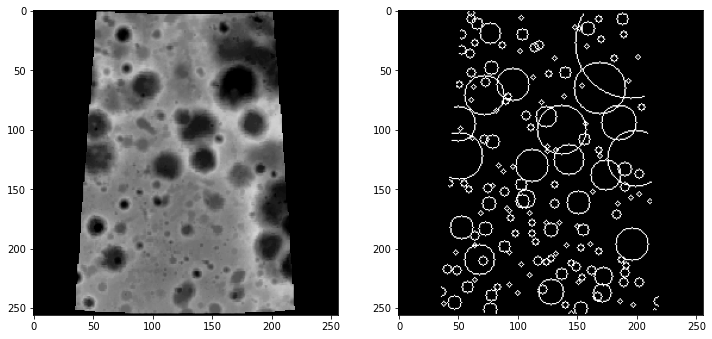

In [18]:
#test image and its mask
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(f['input_images'][17][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][17][...], origin='upper', cmap='Greys_r')
plt.show()

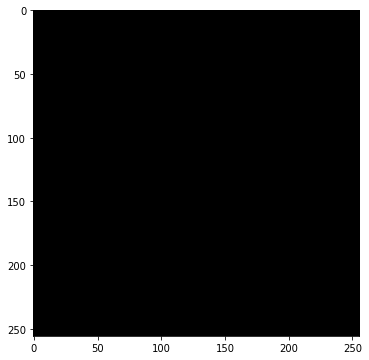

In [19]:
fig = plt.figure(figsize=[12, 6])
ax = fig.subplots(1,1)
ax.imshow(pred_image, origin='upper', cmap='Greys_r')
plt.show()